## Sample test simulation

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a test sim, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
data=data_Chabanier2019.P1D_Chabanier2019(zmax=4.5)

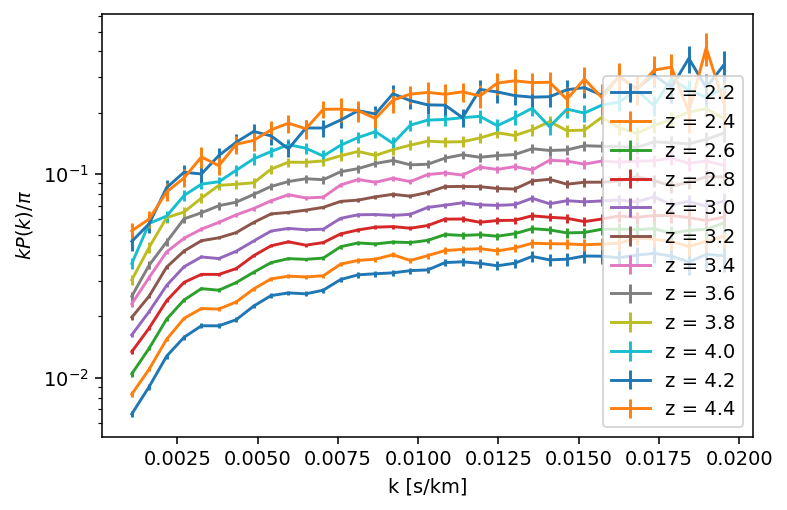

In [3]:
data.plot_p1d()

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [4]:
emulator_label="LaCE-NN"
if emulator_label=="LaCE-GP":
    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif emulator_label=="LaCE-NN":
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [5]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [6]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emulator,
                           free_param_names=free_param_names,
                           prior_Gauss_rms=prior_Gauss_rms,
                           emu_cov_factor=emu_cov_factor)

will not store truth, working with real data


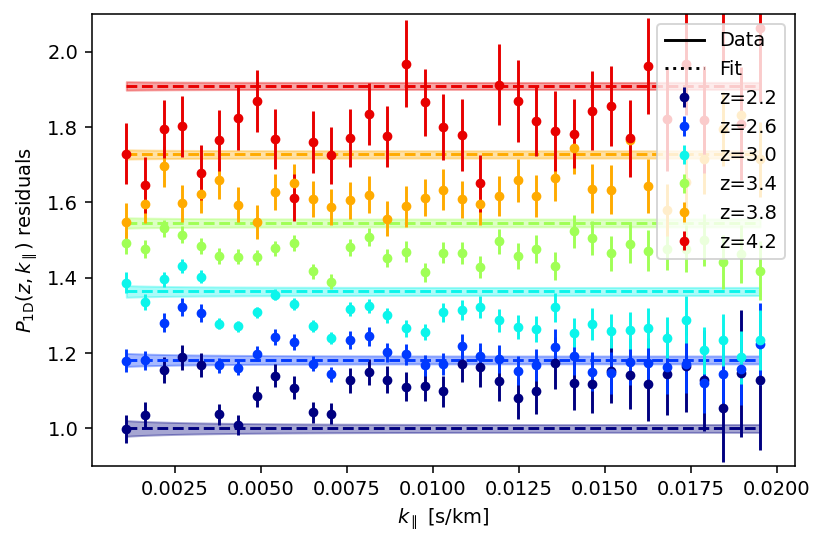

In [7]:
like.plot_p1d(residuals=True,plot_every_iz=2)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [8]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,progress=True)

Created directory: /Users/font/Codes/igmhub/cup1d//chains//chain_24
setup with 16 walkers


In [9]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 0.0 -0.1 0.1
ln_sigT_kms_0 0.0 -0.4 0.4
ln_gamma_0 0.0 -0.2 0.2
ln_kF_0 0.0 -0.2 0.2


In [ ]:
n_burn_in=50
n_steps=500
start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

 11%|████▍                                     | 58/550 [00:28<03:52,  2.12it/s]

In [ ]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

In [ ]:
if free_cosmo:
    sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [ ]:
a=3